Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 external_states. See `.externals` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.
axial_conductances Traced<float64[1998]>with<DynamicJaxprTrace>


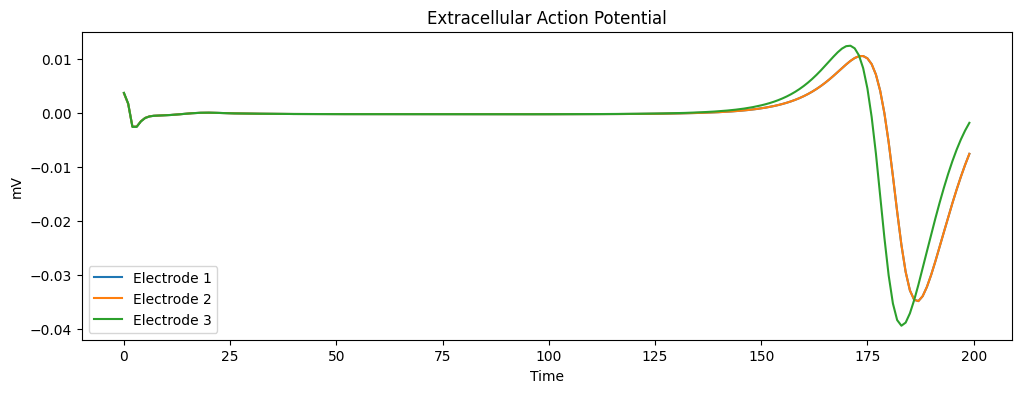

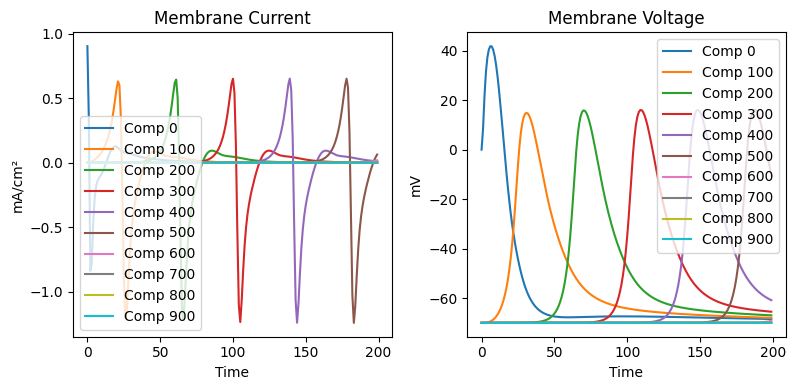

Timing subsequent calls to jitted_predict_ei...
Call 1 took 0.0003 seconds
Call 2 took 0.0002 seconds
Call 3 took 0.0003 seconds
Call 4 took 0.0001 seconds
Call 5 took 0.0001 seconds
Call 6 took 0.0001 seconds
Call 7 took 0.0001 seconds
Call 8 took 0.0001 seconds
Call 9 took 0.0001 seconds
Call 10 took 0.0001 seconds

Average time over 10 calls: 0.0001 seconds
Standard deviation: 0.0001 seconds

Timing jitted_predict_ei with different batch sizes...


TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int64. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

In [ ]:
import straight_axon_model 
import jax.numpy as jnp

cell = straight_axon_model.StraightAxon()

params ={
    "radius": jnp.array([0.75]),
    "axial_resistivity": jnp.array([140]),
    "HH_gNa": jnp.array([0.1]),
    "HH_gK": jnp.array([0.05]),
    "axon_origin_dist": jnp.array([30.0]),
    "axon_theta": jnp.array([0.0]),
    "axon_phi": jnp.array([jnp.pi/2]),
    "axon_spin_angle": jnp.array([0.0])
}

eap, mem_current, mem_voltage = cell.jitted_predict_ei(params)

import matplotlib.pyplot as plt

# Plot EAP for all 3 electrodes
plt.figure(figsize=(12, 4))
for i in range(eap.shape[0]):
    plt.plot(eap[i], label=f'Electrode {i+1}')
plt.title('Extracellular Action Potential')
plt.xlabel('Time')
plt.ylabel('mV')
plt.legend()

# Plot membrane current for every 10th compartment
plt.figure(figsize=(12, 4))
plt.subplot(131)
for i in range(0, mem_current.shape[0], 100):
    plt.plot(mem_current[i], label=f'Comp {i}')
plt.title('Membrane Current')
plt.xlabel('Time')
plt.ylabel('mA/cm²')
plt.legend()

# Plot membrane voltage for every 10th compartment
plt.subplot(132)
for i in range(0, mem_voltage.shape[0], 100):
    plt.plot(mem_voltage[i], label=f'Comp {i}')
plt.title('Membrane Voltage') 
plt.xlabel('Time')
plt.ylabel('mV')
plt.legend()

plt.tight_layout()
plt.show()




# Time subsequent calls to jitted_predict_ei
import time

print("Timing subsequent calls to jitted_predict_ei...")

# First call already happened above, now time 10 more calls
num_trials = 10
times = []

import numpy as np
for i in range(num_trials):
    start = time.time()
    eap, mem_current, mem_voltage = cell.jitted_predict_ei(params)
    end = time.time()
    times.append(end - start)
    print(f"Call {i+1} took {times[-1]:.4f} seconds")

print(f"\nAverage time over {num_trials} calls: {np.mean(times):.4f} seconds")
print(f"Standard deviation: {np.std(times):.4f} seconds")


# Time multiple calls to jitted_predict_ei with different batch sizes
print("\nTiming jitted_predict_ei with different batch sizes...")


opt_params = cell.inverse_sigmoid_transform_parameters(params)

times = []
for batch_size in range(10):
    start = time.time()
    eap, mem_current, mem_voltage = cell.jitted_grad(opt_params)
    end = time.time()
    times.append(end - start)
    print(f"Trial {i+1}: {times[-1]:.4f} seconds")

print(f"\nAverage time over {num_trials} calls: {np.mean(times):.4f} seconds")
print(f"Standard deviation: {np.std(times):.4f} seconds")   








In [24]:
import pickle as pkl
import importlib
import jax.numpy as jnp
import numpy as np

# Import and reload the model
import model
importlib.reload(model)

physical_ei = model.generate_random_gt_params_ei(1)


print("Creating trainer...")
trainer = model.StraightAxon()
print("Trainer created successfully!")
print("Training with physical_ei:", physical_ei)
trainer.train(true_ei=physical_ei)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1 external_states. See `.externals` for details.
Added 1500 recordings. See `.recordings` for details.
Added 1500 recordings. See `.recordings` for details.
Creating trainer...
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Trainer created successfully!
Training with physical_ei: ({'axon_origin_dist': Array([18.83830807], dtype=float64), 'axon

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[]
It arose in the jnp.arange argument 'start'
The error occurred while tracing the function compute_ei_width at /Users/andrewlanpouthakoun/Desktop/Stats220/extracellular-jaxley/exp/loss_functions.py:10 for jit. This concrete value was not available in Python because it depends on the value of the argument max_time_offset.

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError